# Stock Price Prediction with LSTM

1. [Preprocess Data](#Preprocess-Data)
2. [Stacked LSTM](#Stacked-LSTM)
3. [Encoder-Decoder LSTM](#Encoder-Decoder-LSTM)
4. [Encoder-Decoder LSTM with Attention](#Encoder-Decoder-LSTM-with-Attention)

# Preprocess Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Input, \
    multiply, concatenate, Activation, dot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from util import get_features_labels

In [2]:
plt.rcParams["figure.figsize"] = (16, 8)

In [3]:
INPUT_PATH = 'data/'
OUTPUT_PATH = 'output/'
TICKER = 'amzn'
TRAIN_START = '20150101'
TEST_START = '20200101'
SEQ_LEN = 60
FORECAST_HORIZON = 1
N_HIDDEN = 50

In [4]:
# Load data
df = pd.read_csv(INPUT_PATH + TICKER + '.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True) # In case the data is not sorted
df.sort_index(ascending=True, axis=0, inplace=True)
df.tail()

,open,high,close,volume
date,,,,
2020-11-12,3159.95,3175.88,3110.28,4371208.0
2020-11-13,3122.00,3141.72,3128.81,3762587.0
2020-11-16,3093.20,3142.70,3131.06,3808676.0
2020-11-17,3183.54,3189.25,3135.66,3444735.0
2020-11-18,3134.00,3140.00,3105.46,2881216.0


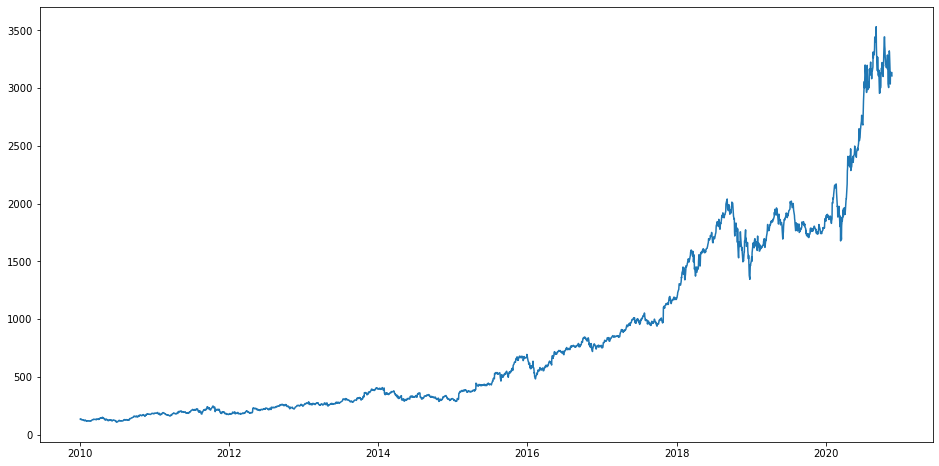

In [5]:
# Plot the data
plt.plot(df['close'])

In [6]:
# Get close price only starting from the TRAIN_START date
data = df.loc[df.index >= TRAIN_START, 'close'].to_frame()
# Split data into training and test sets
train = data.loc[data.index < TEST_START]
test = data.loc[data.index >= TEST_START]

In [7]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [8]:
# Get training data
X_train, y_train = get_features_labels(train_scaled, SEQ_LEN)
# Get test data
X_test, _ = get_features_labels(test_scaled, SEQ_LEN)

# Stacked LSTM

In [9]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=N_HIDDEN, activation='elu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=N_HIDDEN, activation='elu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.3, verbose=2)
model.save('models/{}_stacked_lstm.h5'.format(TICKER))

Epoch 1/100
27/27 - 15s - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 2/100
27/27 - 13s - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/100
27/27 - 13s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/100
27/27 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 5/100
27/27 - 13s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/100
27/27 - 12s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/100
27/27 - 12s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/100
27/27 - 12s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 9/100
27/27 - 16s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 10/100
27/27 - 16s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 11/100
27/27 - 18s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 12

Epoch 86/100
27/27 - 11s - loss: 6.3341e-04 - mse: 6.3341e-04 - val_loss: 7.8244e-04 - val_mse: 7.8244e-04
Epoch 87/100
27/27 - 12s - loss: 5.7613e-04 - mse: 5.7613e-04 - val_loss: 8.4108e-04 - val_mse: 8.4108e-04
Epoch 88/100
27/27 - 11s - loss: 6.3665e-04 - mse: 6.3665e-04 - val_loss: 8.9288e-04 - val_mse: 8.9288e-04
Epoch 89/100
27/27 - 11s - loss: 4.4409e-04 - mse: 4.4409e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 90/100
27/27 - 11s - loss: 5.4572e-04 - mse: 5.4572e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 91/100
27/27 - 12s - loss: 5.6611e-04 - mse: 5.6611e-04 - val_loss: 8.0966e-04 - val_mse: 8.0966e-04
Epoch 92/100
27/27 - 12s - loss: 5.2150e-04 - mse: 5.2150e-04 - val_loss: 7.4725e-04 - val_mse: 7.4725e-04
Epoch 93/100
27/27 - 11s - loss: 5.7758e-04 - mse: 5.7758e-04 - val_loss: 8.9035e-04 - val_mse: 8.9035e-04
Epoch 94/100
27/27 - 11s - loss: 4.8341e-04 - mse: 4.8341e-04 - val_loss: 9.0263e-04 - val_mse: 9.0263e-04
Epoch 95/100
27/27 - 12s - loss: 5.3608e-04 - mse: 5.

In [9]:
# Load the best saved model
model = load_model('models/{}_stacked_lstm.h5'.format(TICKER))

In [10]:
# Make predictions
preds = model.predict(X_test)
preds_unscaled = scaler.inverse_transform(preds)
preds_unscaled = pd.DataFrame(data=preds_unscaled, index=test.index[test.shape[0] - preds_unscaled.shape[0]:])

In [11]:
# Shift preds up by 1 so that it's convenient for backtesting
preds_shifted = preds_unscaled.shift(-1)
# Merge all into 1 dataframe and save results into a csv
res = df.merge(preds_shifted, how='right', left_index=True, right_index=True)
res.rename(columns={0: 'preds'}, inplace=True)
res.to_csv('{}{}_preds_stacked_lstm.csv'.format(OUTPUT_PATH, TICKER))
res.head()

,open,high,close,volume,preds
date,,,,,
2020-03-30,1922.83,1973.63,1963.95,6126087.0,1918.177490
2020-03-31,1964.35,1993.02,1949.72,5071342.0,1925.851318
2020-04-01,1932.97,1944.96,1907.70,4086565.0,1921.523071
2020-04-02,1901.64,1927.53,1918.83,4305149.0,1915.097900
2020-04-03,1911.15,1926.33,1906.59,3609870.0,1905.871826


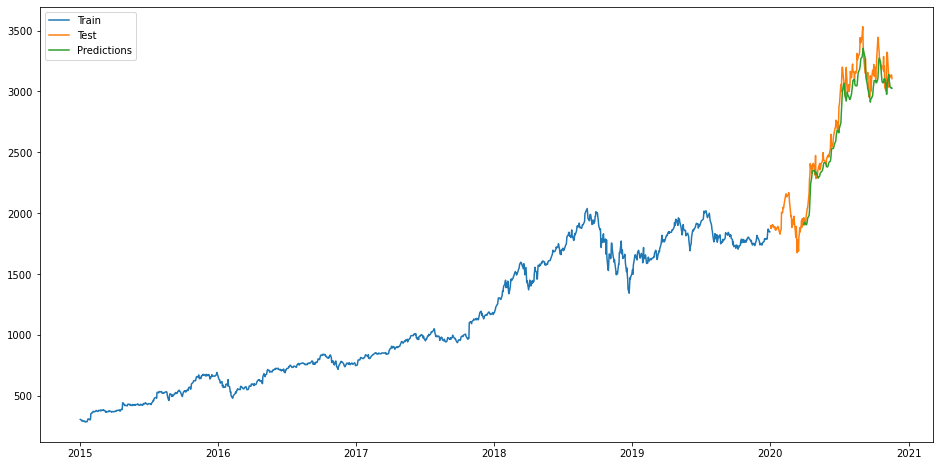

In [12]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(preds_unscaled, label='Predictions')
plt.legend()

In [13]:
# Get MSEs
train_mse = history.history['mse']
valid_mse = history.history['val_mse']
test_mse = mean_squared_error(test[test.shape[0] - preds_unscaled.shape[0]:], preds_unscaled)
test_mse

15951.036035555664

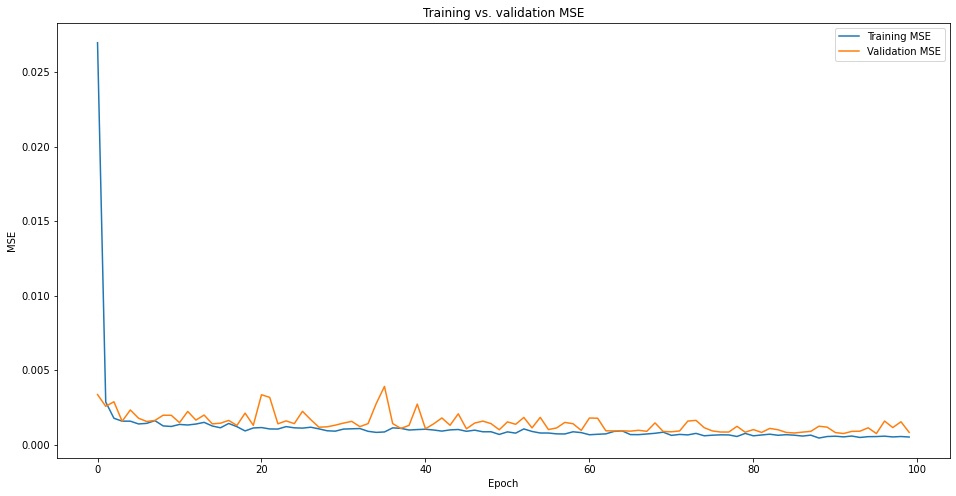

In [14]:
plt.plot(train_mse, label='Training MSE'), 
plt.plot(valid_mse, label='Validation MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Training vs. validation MSE')
plt.legend()

# Encoder-Decoder LSTM

In [9]:
y_train = np.reshape(y_train, (y_train.shape[0], FORECAST_HORIZON, 1))

In [10]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    units=N_HIDDEN, activation='elu',
    return_sequences=False, return_state=True)(input_train)

decoder = RepeatVector(output_train.shape.as_list()[1])(encoder_last_h1)
decoder = LSTM(units=N_HIDDEN, activation='elu',
               return_state=False, return_sequences=True)(
    decoder, initial_state=(encoder_last_h1, encoder_last_c))
decoder = Dropout(rate=0.2)(decoder)
out = TimeDistributed(Dense(1))(decoder)

model = Model(inputs=input_train, outputs=out)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.3, verbose=2)
model.save('models/{}_encoder_decoder_lstm.h5'.format(TICKER))

Epoch 1/100
27/27 - 8s - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 2/100
27/27 - 7s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/100
27/27 - 8s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/100
27/27 - 6s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/100
27/27 - 6s - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/100
27/27 - 8s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/100
27/27 - 7s - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 8/100
27/27 - 8s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 9/100
27/27 - 8s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 10/100
27/27 - 8s - loss: 0.0014 - mse: 0.0014 - val_loss: 9.8706e-04 - val_mse: 9.8706e-04
Epoch 11/100
27/27 - 8s - loss: 0.0012 - mse: 0.0012 - val_loss: 9.7978e-04 - val_mse: 9.7978e-04
Epo

Epoch 83/100
27/27 - 8s - loss: 6.0303e-04 - mse: 6.0303e-04 - val_loss: 8.3966e-04 - val_mse: 8.3966e-04
Epoch 84/100
27/27 - 9s - loss: 6.7082e-04 - mse: 6.7082e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 85/100
27/27 - 9s - loss: 6.1712e-04 - mse: 6.1712e-04 - val_loss: 6.0853e-04 - val_mse: 6.0853e-04
Epoch 86/100
27/27 - 9s - loss: 5.5032e-04 - mse: 5.5032e-04 - val_loss: 5.9583e-04 - val_mse: 5.9583e-04
Epoch 87/100
27/27 - 9s - loss: 6.2381e-04 - mse: 6.2381e-04 - val_loss: 5.9426e-04 - val_mse: 5.9426e-04
Epoch 88/100
27/27 - 9s - loss: 5.5823e-04 - mse: 5.5823e-04 - val_loss: 6.1010e-04 - val_mse: 6.1010e-04
Epoch 89/100
27/27 - 9s - loss: 5.9985e-04 - mse: 5.9985e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 90/100
27/27 - 8s - loss: 6.5509e-04 - mse: 6.5509e-04 - val_loss: 8.1545e-04 - val_mse: 8.1545e-04
Epoch 91/100
27/27 - 7s - loss: 4.9448e-04 - mse: 4.9448e-04 - val_loss: 6.3158e-04 - val_mse: 6.3158e-04
Epoch 92/100
27/27 - 6s - loss: 5.0384e-04 - mse: 5.0384e-04 -

In [13]:
# Load the best saved model
model = load_model('models/{}_encoder_decoder_lstm.h5'.format(TICKER))

In [14]:
# Make predictions
preds = model.predict(X_test)
preds_unscaled = scaler.inverse_transform(np.reshape(preds, (preds.shape[0], 1)))
preds_unscaled = pd.DataFrame(data=preds_unscaled, index=test.index[test.shape[0] - preds_unscaled.shape[0]:])

In [15]:
# Shift preds up by 1 so that it's convenient for backtesting
preds_shifted = preds_unscaled.shift(-1)
# Merge all into 1 dataframe and save results into a csv
res = df.merge(preds_shifted, how='right', left_index=True, right_index=True)
res.rename(columns={0: 'preds'}, inplace=True)
res.to_csv('{}{}_preds_encoder_decoder_lstm.csv'.format(OUTPUT_PATH, TICKER))
res.head()

,open,high,close,volume,preds
date,,,,,
2020-03-30,1922.83,1973.63,1963.95,6126087.0,1950.987915
2020-03-31,1964.35,1993.02,1949.72,5071342.0,1958.565918
2020-04-01,1932.97,1944.96,1907.70,4086565.0,1947.834839
2020-04-02,1901.64,1927.53,1918.83,4305149.0,1943.265625
2020-04-03,1911.15,1926.33,1906.59,3609870.0,1934.743896


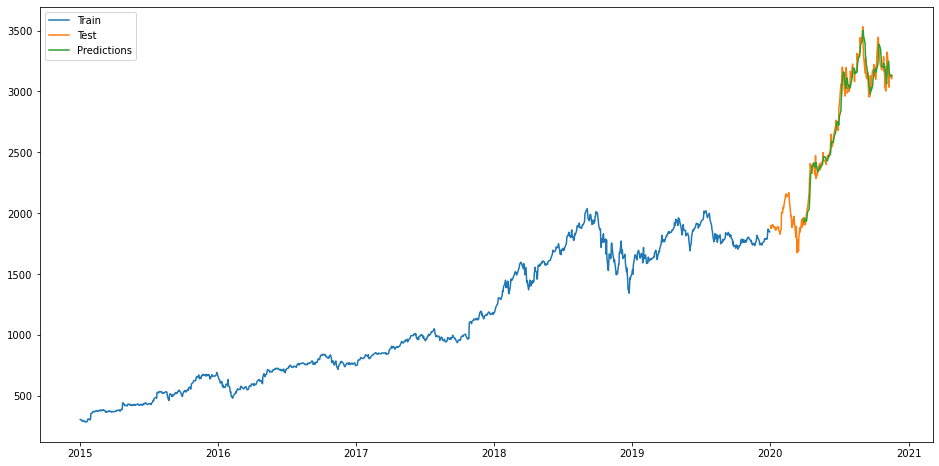

In [13]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(preds_unscaled, label='Predictions')
plt.legend()

In [14]:
# Get MSEs
train_mse = history.history['mse']
valid_mse = history.history['val_mse']
test_mse = mean_squared_error(test[test.shape[0] - preds_unscaled.shape[0]:], preds_unscaled)
test_mse

6658.551444694573

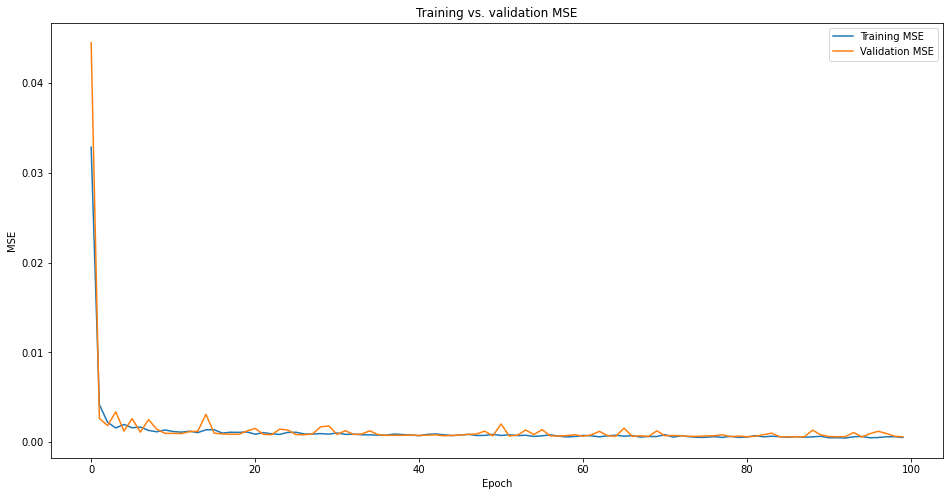

In [15]:
plt.plot(train_mse, label='Training MSE'), 
plt.plot(valid_mse, label='Validation MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Training vs. validation MSE')
plt.legend()

# Encoder-Decoder LSTM with Attention

In [9]:
y_train = np.reshape(y_train, (y_train.shape[0], FORECAST_HORIZON, 1))

In [10]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    units=N_HIDDEN, activation='elu',
    return_state=True, return_sequences=True)(input_train)

decoder_input = RepeatVector(output_train.shape.as_list()[1])(encoder_last_h)
decoder_stack_h = LSTM(units=N_HIDDEN, activation='elu',
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
decoder_combined_context = concatenate([context, decoder_stack_h])
decoder_combined_context = Dropout(rate=0.2)(decoder_combined_context)
out = TimeDistributed(Dense(1))(decoder_combined_context)

model = Model(inputs=input_train, outputs=out)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.3, verbose=2)
model.save('models/{}_encoder_decoder_lstm_attention.h5'.format(TICKER))

Epoch 1/100
27/27 - 5s - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 2/100
27/27 - 5s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/100
27/27 - 4s - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/100
27/27 - 4s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 5/100
27/27 - 4s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/100
27/27 - 4s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/100
27/27 - 5s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 8/100
27/27 - 5s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 9/100
27/27 - 5s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 10/100
27/27 - 6s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 11/100
27/27 - 6s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 12/100
27/27 

Epoch 86/100
27/27 - 6s - loss: 4.7883e-04 - mse: 4.7883e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 87/100
27/27 - 6s - loss: 4.7063e-04 - mse: 4.7063e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 88/100
27/27 - 6s - loss: 5.3823e-04 - mse: 5.3823e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 89/100
27/27 - 6s - loss: 4.8923e-04 - mse: 4.8923e-04 - val_loss: 7.8596e-04 - val_mse: 7.8596e-04
Epoch 90/100
27/27 - 6s - loss: 5.3648e-04 - mse: 5.3648e-04 - val_loss: 7.9881e-04 - val_mse: 7.9881e-04
Epoch 91/100
27/27 - 6s - loss: 5.2559e-04 - mse: 5.2559e-04 - val_loss: 7.8499e-04 - val_mse: 7.8499e-04
Epoch 92/100
27/27 - 6s - loss: 4.6824e-04 - mse: 4.6824e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 93/100
27/27 - 6s - loss: 4.7059e-04 - mse: 4.7059e-04 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 94/100
27/27 - 6s - loss: 5.0342e-04 - mse: 5.0342e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 95/100
27/27 - 6s - loss: 4.9487e-04 - mse: 4.9487e-04 - val_loss: 8.6780e-04 - val_mse:

In [16]:
# Load the best saved model
model = load_model('models/{}_encoder_decoder_lstm_attention.h5'.format(TICKER))

In [17]:
# Make predictions
preds = model.predict(X_test)
preds_unscaled = scaler.inverse_transform(np.reshape(preds, (preds.shape[0], 1)))
preds_unscaled = pd.DataFrame(data=preds_unscaled, index=test.index[test.shape[0] - preds_unscaled.shape[0]:])

In [18]:
# Shift preds up by 1 so that it's convenient for backtesting
preds_shifted = preds_unscaled.shift(-1)
# Merge all into 1 dataframe and save results into a csv
res = df.merge(preds_shifted, how='right', left_index=True, right_index=True)
res.rename(columns={0: 'preds'}, inplace=True)
res.to_csv('{}{}_preds_encoder_decoder_attention_lstm.csv'.format(OUTPUT_PATH, TICKER))
res.head()

,open,high,close,volume,preds
date,,,,,
2020-03-30,1922.83,1973.63,1963.95,6126087.0,2026.650269
2020-03-31,1964.35,1993.02,1949.72,5071342.0,2030.942993
2020-04-01,1932.97,1944.96,1907.70,4086565.0,2016.283813
2020-04-02,1901.64,1927.53,1918.83,4305149.0,2006.055054
2020-04-03,1911.15,1926.33,1906.59,3609870.0,1992.477661


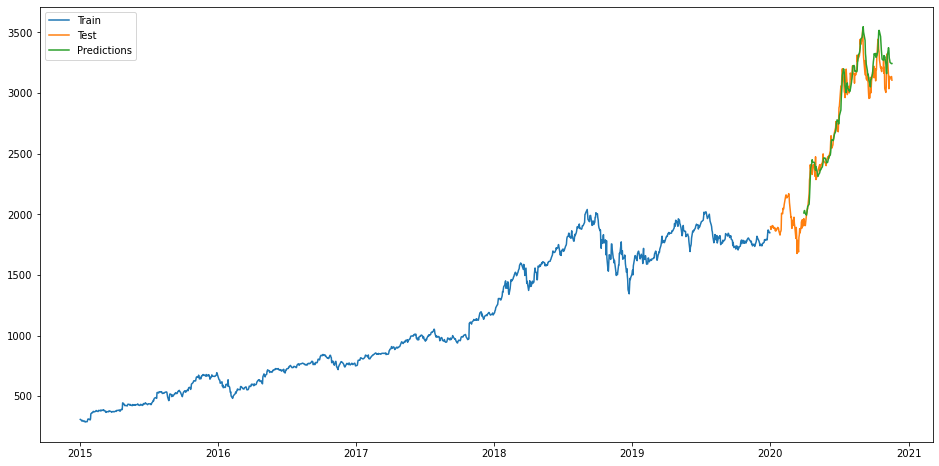

In [13]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(preds_unscaled, label='Predictions')
plt.legend()

In [14]:
# Get MSEs
train_mse = history.history['mse']
valid_mse = history.history['val_mse']
test_mse = mean_squared_error(test[test.shape[0] - preds_unscaled.shape[0]:], preds_unscaled)
test_mse

10159.052104025426

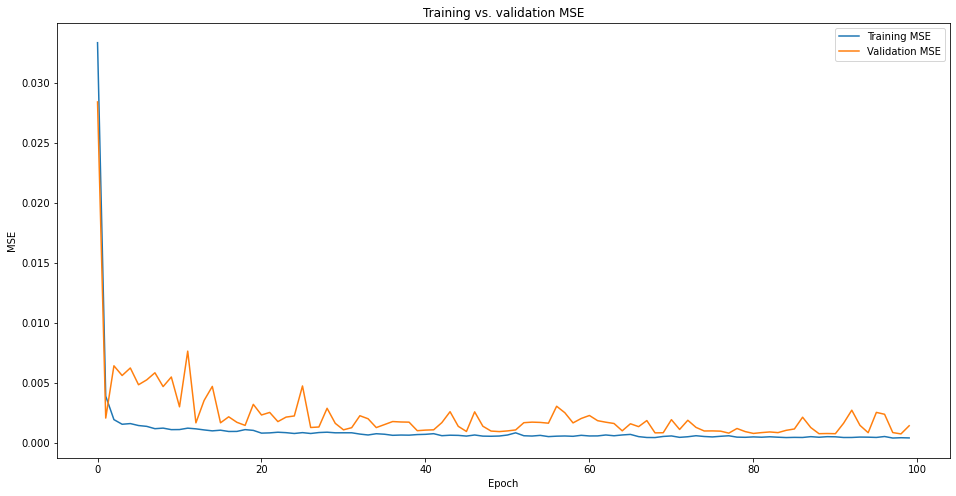

In [15]:
plt.plot(train_mse, label='Training MSE'), 
plt.plot(valid_mse, label='Validation MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Training vs. validation MSE')
plt.legend()